In [1]:
from __future__ import print_function

"""
A reference implementation of cavity quantum electrodynamics 
configuration interactions singles.
"""

__authors__   = ["Jon McTague", "Jonathan Foley"]
__credits__   = ["Jon McTague", "Jonathan Foley"]

__copyright_amp__ = "(c) 2014-2018, The Psi4NumPy Developers"
__license__   = "BSD-3-Clause"
__date__      = "2021-01-15"

# ==> Import Psi4, NumPy, & SciPy <==
import psi4
import numpy as np
import scipy.linalg as la
import time
from helper_cqed_rhf import *
from helper_cis import *
from helper_cs_cqed_cis import *
from psi4.driver.procrouting.response.scf_response import tdscf_excitations

# Set Psi4 & NumPy Memory Options
psi4.set_memory('2 GB')
#psi4.core.set_output_file('output.dat', False)

numpy_memory = 2


In [2]:
from matplotlib import pyplot as plt

mol_tmpl = """Mg
H 1 **R**
symmetry c1
1 1"""

# options dict
options_dict = {'basis': 'cc-pVDZ',
               'save_jk': True, 
               'scf_type': 'pk',
               'e_convergence' : 1e-7,
               'd_convergence' : 1e-6}

# set psi4 options and geometry
psi4.set_options(options_dict)
#mol = psi4.geometry(mol_t)


r_array = np.array([1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3])

# array for ordinary cis
cqed_rhf_energy_array = np.zeros((16,len(r_array)))


# electric field strength 
lam_z = 0.05


# lambda vector
lam = np.array([0,0,lam_z])
nolam = np.array([0,0,0])



# loop over the different bond-lengths, create different instances
# of MgH+ molecule and compute and store various quantities
ctr = 0
"""
for r in r_array:
    molstr = mol_tmpl.replace("**R**", str(r))
    cqed_dict = cqed_rhf(nolam, molstr, options_dict)
    
    # get cqed-rhf energy
    cqed_rhf_energy_array[0,ctr] = cqed_dict['CQED-RHF ENERGY']
    cqed_rhf_energy_array[1,ctr] = cqed_dict['1E ENERGY']
    cqed_rhf_energy_array[2,ctr] = cqed_dict['2E ENERGY']
    cqed_rhf_energy_array[3,ctr] = cqed_dict['1E DIPOLE ENERGY']
    cqed_rhf_energy_array[4,ctr] = cqed_dict['1E QUADRUPOLE ENERGY']
    cqed_rhf_energy_array[5,ctr] = cqed_dict['2E DIPOLE ENERGY']
    cqed_rhf_energy_array[6,ctr] = cqed_dict['DIPOLE ENERGY']
    cqed_rhf_energy_array[7,ctr] = cqed_dict['NUCLEAR REPULSION ENERGY']
    cqed_dict = cqed_rhf(lam, molstr, options_dict)
    cqed_rhf_energy_array[8,ctr] = cqed_dict['CQED-RHF ENERGY']
    cqed_rhf_energy_array[9,ctr] = cqed_dict['1E ENERGY']
    cqed_rhf_energy_array[10,ctr] = cqed_dict['2E ENERGY']
    cqed_rhf_energy_array[11,ctr] = cqed_dict['1E DIPOLE ENERGY']
    cqed_rhf_energy_array[12,ctr] = cqed_dict['1E QUADRUPOLE ENERGY']
    cqed_rhf_energy_array[13,ctr] = cqed_dict['2E DIPOLE ENERGY']
    cqed_rhf_energy_array[14,ctr] = cqed_dict['DIPOLE ENERGY']
    cqed_rhf_energy_array[15,ctr] = cqed_dict['NUCLEAR REPULSION ENERGY']
    
    ctr+=1
    
"""

'\nfor r in r_array:\n    molstr = mol_tmpl.replace("**R**", str(r))\n    cqed_dict = cqed_rhf(nolam, molstr, options_dict)\n    \n    # get cqed-rhf energy\n    cqed_rhf_energy_array[0,ctr] = cqed_dict[\'CQED-RHF ENERGY\']\n    cqed_rhf_energy_array[1,ctr] = cqed_dict[\'1E ENERGY\']\n    cqed_rhf_energy_array[2,ctr] = cqed_dict[\'2E ENERGY\']\n    cqed_rhf_energy_array[3,ctr] = cqed_dict[\'1E DIPOLE ENERGY\']\n    cqed_rhf_energy_array[4,ctr] = cqed_dict[\'1E QUADRUPOLE ENERGY\']\n    cqed_rhf_energy_array[5,ctr] = cqed_dict[\'2E DIPOLE ENERGY\']\n    cqed_rhf_energy_array[6,ctr] = cqed_dict[\'DIPOLE ENERGY\']\n    cqed_rhf_energy_array[7,ctr] = cqed_dict[\'NUCLEAR REPULSION ENERGY\']\n    cqed_dict = cqed_rhf(lam, molstr, options_dict)\n    cqed_rhf_energy_array[8,ctr] = cqed_dict[\'CQED-RHF ENERGY\']\n    cqed_rhf_energy_array[9,ctr] = cqed_dict[\'1E ENERGY\']\n    cqed_rhf_energy_array[10,ctr] = cqed_dict[\'2E ENERGY\']\n    cqed_rhf_energy_array[11,ctr] = cqed_dict[\'1E DIPOLE ENE

In [ ]:
plt.plot(r_array, 100*(cqed_rhf_energy_array[11,:]-cqed_rhf_energy_array[3,:])/cqed_rhf_energy_array[0,:])
plt.plot()

In [8]:
# functions for Pauli-Fierz and Jaynes-Cummings model Hamiltonians

def pauli_fierz(e1, e2, omega, lam, mu_g, mu_e, mu_eg):
    H = np.zeros((3,3),dtype=complex)
    l_d_mu_g = np.dot(lam, mu_g)
    l_d_mu_e = np.dot(lam, mu_e)
    l_d_tdm  = np.dot(lam, mu_eg)
    
    H[0,0] = e1 + 0.5 * l_d_mu_g ** 2
    H[1,1] = e1 + omega + 0.5 * l_d_mu_g ** 2
    H[2,2] = e2 + 0.5 * l_d_mu_e ** 2
    H[1,2] = np.sqrt(omega/2) * l_d_tdm
    H[2,1] = np.sqrt(omega/2) * l_d_tdm

    
    # diagonalize
    vals, vecs = la.eig(H)
    idx = vals.argsort()[::1]
    vals = vals[idx]
    return vals[0], vals[1], vals[2]

def jaynes_cummings(e1, e2, omega, lam, mu_eg):
    H = np.zeros((3,3),dtype=complex)
    l_d_tdm = np.dot(lam, mu_eg)
    H[0,0] = e1 + omega
    H[1,1] = e2
    H[0,1] = np.sqrt(omega/2) * l_d_tdm
    H[1,0] = np.sqrt(omega/2) * l_d_tdm
    # diagonalize
    vals, vecs = la.eig(H)
    idx = vals.argsort()[::1]
    vals = vals[idx]
    return vals[0], vals[1]


# Quick validation
In the next cell, we will just run a quick test of helper_cis() and helper_cqed_cis() against psi4's CIS.
Note that helper_cis is just ordinary cis but also returns the dipole expectation value of
excited CIS states, which to my knowledge is not available through psi4.
The function helper_cs_cqed_cis() is the cqed-cis method in the coherent state basis.
If the lambda_vector = 0, then all three of these methods should return the same excited-state energies.

In [3]:
mol_str = """
Mg
H 1 1.3
symmetry c1
1 1
"""

# options dict
options_dict = {'basis': 'cc-pVDZ',
               'save_jk': True, 
               'scf_type': 'pk'}

# set psi4 options and geometry
psi4.set_options(options_dict)
mol = psi4.geometry(mol_str)

om = 0.
lam = np.array([0.,0.,0.])

n_states = 5

# run psi4 SCF
psi4_rhf_e, wfn = psi4.energy("scf/cc-pVDZ", return_wfn=True, molecule=mol)
    
# calculate the excited-state energies and save them to a dictionary called 'res'
res = tdscf_excitations(wfn, states=n_states, triplets = "NONE", tda=True)

# parse res for excitation energies
psi4_excitation_e = [r["EXCITATION ENERGY"] for r in res]

# run helper_cis()
cis_e, cis_mu, tdm = cis(mol_str, options_dict)

# run helper_cs_cqed_cis()
cqed_dict = cs_cqed_cis(lam, om, mol_str, options_dict)

cqed_cis_e = cqed_dict['CQED-CIS ENERGY']
scf_e = cqed_dict['RHF ENERGY']

# collect corresponding excitation energies for comparison
cqed_cis_to_compare = cqed_cis_e[::2]

# check to see that the cis energies match psi4s!
assert( np.isclose(psi4_rhf_e, scf_e))
assert( np.allclose(psi4_excitation_e, cis_e[:n_states]))
assert( np.allclose(psi4_excitation_e, cqed_cis_to_compare[1:n_states+1]))
print(cis_mu[:,0])


Number of occupied orbitals: 6

Start SCF iterations:

Canonical RHF One-electron energy = -285.7424508862669086
CQED-RHF One-electron energy      = -285.7424508862669086
Nuclear repulsion energy          = 4.8847127138769242
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -199.8574439988287565   dE = -1.99857E+02   dRMS = 1.39184E-08
SCF Iteration   2: Energy = -199.8574439988287565   dE =  0.00000E+00   dRMS = 3.89537E-09
Total time for SCF iterations: 0.005 seconds 

QED-RHF   energy: -199.85744400 hartree
Psi4  SCF energy: -199.85744400 hartree
[ 2.23154493e-16 -5.39074991e-16 -1.57800173e+00]


# MgH+ Polaritonic Potential Energy Surfaces
Create a template for the z-matrix that can be modified for different bond-lengths

Run a scan of the SCF, CIS, and CS-CQED-CIS energies

In [37]:
# set psi4 options
psi4.set_options(options_dict)
# array of bondlengths for MgH+
r_array = np.array([1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3, 2.4, 2.5, 2.6, 2.7]) #, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3])

# arrays to hold psi4 cis quantities to fit the model PF Hamiltonian with
# array for transition dipole moments
tdm_array = np.zeros((3, len(r_array)))

# array for total diplole of ground and excited state 
dipole_array = np.zeros((3,2,len(r_array)))

# array for ordinary cis
cis_energy_array = np.zeros((5,len(r_array)))

# array to hold the cs-cqed-cis energies
# array for cqed cis
cqed_cis_energy_array = np.zeros((5,len(r_array)),dtype=complex)

# array for model Pauli-Fierz energies
pf = np.zeros((3,len(r_array)),dtype=complex)

# array for Jaynes-Cummings energies
jc = np.zeros((2,len(r_array)),dtype=complex)

# electric field strength 
lam_z = 0.0125

# photon energy
om_r = 4.75 / 27.211

# approximate maximum value of transition dipole moment in a.u.
max_tdm = 2.25

# approximate max value of g
g_max = np.sqrt(om_r/2) * lam_z * max_tdm

print(" value of gamma to cross over from weak to strong coupling:", 4 * g_max)
om = om_r - 0 * (g_max/2) * 1j

# lambda vector
lam = np.array([0,0,lam_z])




# loop over the different bond-lengths, create different instances
# of MgH+ molecule and compute and store various quantities
ctr = 0
for r in r_array:
    molstr = mol_tmpl.replace("**R**", str(r))
    mol = psi4.geometry(molstr)
    e, wfn = psi4.energy("scf/cc-pVDZ", return_wfn=True, molecule=mol)
    
    # confirm our cis agrees with psi4
    res = tdscf_excitations(wfn, states=3, triplets = "NONE", tda=True)
    
    # parse res for excitation energies
    psi4_excitation_e = [r["EXCITATION ENERGY"] for r in res]
    
    cis_e, cis_mu, tdm = cis(molstr, options_dict)
    
    cis_energy_array[0,ctr] = e
    cis_energy_array[1:5,ctr] = e+cis_e[0:4]
    
    pf[0,ctr], pf[1,ctr], pf[2,ctr] = pauli_fierz(e, e+cis_e[0], om, lam, cis_mu[:,0], cis_mu[:,1], tdm)
    jc[0,ctr], jc[1,ctr] = jaynes_cummings(e, e+cis_e[0], om, lam,  tdm)
    
    assert np.isclose(cis_e[0], psi4_excitation_e[0])
    assert np.isclose(cis_e[1], psi4_excitation_e[1])
    
    cqed_dict = cs_cqed_cis(lam, om, molstr, options_dict)
    
    # get cqed-rhf energy
    cqed_scf_e = cqed_dict['CQED-RHF ENERGY']
    # get cqed-cis excitation energies
    cqed_cis_e = cqed_dict['CQED-CIS ENERGY']
    # store to arrays
    cqed_cis_energy_array[0:5,ctr] = cqed_scf_e+cqed_cis_e[0:5]
    #f.write("%6.3f %12.6f %12.6f %12.6f %12.6f %12.6f %12.6f  \n" % 
    #        (r, cis_energy_array[0,ctr]+np.real(om), cis_energy_array[1,ctr], 
    #        np.real(cqed_cis_energy_array[1,ctr]),np.imag(cqed_cis_energy_array[1,ctr]), 
    #        np.real(cqed_cis_energy_array[2,ctr]),np.imag(cqed_cis_energy_array[2,ctr])))
    ctr+=1
    

 

 value of gamma to cross over from weak to strong coupling: 0.033236254686047906

Number of occupied orbitals: 6

Start SCF iterations:

Canonical RHF One-electron energy = -285.7424508862669086
CQED-RHF One-electron energy      = -285.7427107785730414
Nuclear repulsion energy          = 4.8847127138769242
Dipole energy                     = 0.0005894578078457
SCF Iteration   1: Energy = -199.8571358583262452   dE = -1.99857E+02   dRMS = 1.41945E-05
SCF Iteration   2: Energy = -199.8571361304875040   dE = -2.72161E-07   dRMS = 5.13887E-06
SCF Iteration   3: Energy = -199.8571361628394811   dE = -3.23520E-08   dRMS = 1.92840E-06
SCF Iteration   4: Energy = -199.8571361673715785   dE = -4.53210E-09   dRMS = 7.27631E-07
Total time for SCF iterations: 0.009 seconds 

QED-RHF   energy: -199.85713617 hartree
Psi4  SCF energy: -199.85744400 hartree

Number of occupied orbitals: 6

Start SCF iterations:

Canonical RHF One-electron energy = -285.0750814439016381
CQED-RHF One-electron energy    


Number of occupied orbitals: 6

Start SCF iterations:

Canonical RHF One-electron energy = -281.3940415713063317
CQED-RHF One-electron energy      = -281.3941329010040704
Nuclear repulsion energy          = 2.7609245774086961
Dipole energy                     = 0.0009733918296131
SCF Iteration   1: Energy = -199.8536553751270901   dE = -1.99854E+02   dRMS = 2.68783E-05
SCF Iteration   2: Energy = -199.8536567202606591   dE = -1.34513E-06   dRMS = 1.01773E-05
SCF Iteration   3: Energy = -199.8536568789993453   dE = -1.58739E-07   dRMS = 3.79691E-06
SCF Iteration   4: Energy = -199.8536569014482325   dE = -2.24489E-08   dRMS = 1.44312E-06
SCF Iteration   5: Energy = -199.8536569046876252   dE = -3.23939E-09   dRMS = 5.49590E-07
Total time for SCF iterations: 0.012 seconds 

QED-RHF   energy: -199.85365690 hartree
Psi4  SCF energy: -199.85434279 hartree

Number of occupied orbitals: 6

Start SCF iterations:

Canonical RHF One-electron energy = -281.1460261360032860
CQED-RHF One-electron 

In [34]:
#safe_jc = np.copy(jc)
#safe_pf = np.copy(pf)
#safe_cqed_cis = np.copy(cqed_cis_energy_array)
print(r_array[9:])
#tmp = np.copy(cqed_cis_energy_array[1,9:])
#cqed_cis_energy_array[1,9:] = np.copy(cqed_cis_energy_array[2,9:])
#cqed_cis_energy_array[2,9:] = np.copy(tmp)

#tmp_jc_lp = jc[1,9:]
#tmp_pf_up = pf[1,9:]
#tmp_pf_lp = pf[2,9:]
#tmp_cqed_cis_up = cqed_cis_energy_array[1,9:]
#tmp_cqed_cis_lp = cqed_cis_energy_array[2,9:]

#jc = np.copy(safe_jc)
#pf = np.copy(safe_pf)
#cqed_cis_energy_array = np.copy(safe_cqed_cis)

[2.2 2.3 2.4 2.5 2.6 2.7]


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


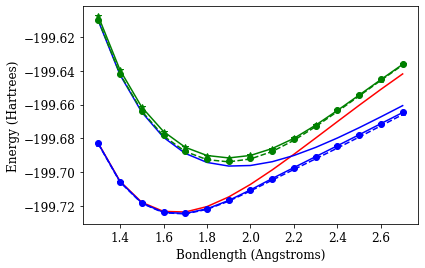

In [39]:
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import rcParams


rcParams['font.family'] = 'serif'
rcParams['font.size'] = 12

plt.plot(r_array, cis_energy_array[0,:]+om, 'red', label='X,1')
plt.plot(r_array, cis_energy_array[1,:], 'blue', label='A,0')
plt.plot(r_array, np.real(jc[0,:]), 'b--', label="JC LP")
plt.plot(r_array, np.real(jc[1,:]), 'g--', label="JC UP")
plt.plot(r_array, np.real(pf[1,:]), 'b-*', label="PF LP")
plt.plot(r_array, np.real(pf[2,:]), 'g-*', label="PF UP")
plt.plot(r_array, np.real(cqed_cis_energy_array[1,:]), 'bo', label="CQED-CIS LP")
plt.plot(r_array, np.real(cqed_cis_energy_array[2,:]), 'go', label="CQED-CIS UP")

plt.xlabel("Bondlength (Angstroms)")
plt.ylabel("Energy (Hartrees)")
#plt.legend()
#plt.savefig("mghplus_stretch.eps")
plt.show()

OLD CODE BELOW!

In [40]:
f = open('MgH_ccpVDZ_Ez_12.5mH_om_4.75_0g.txt', 'w')
stri = "radius; CIS X,1; CIS A,0; JC LP; JC UP; PF LP; PF UP; CQED-CIS LP; CQED-CIS UP"
f.write(" %s \n" % stri)
ctr=0
for r in r_array:
    f.write("%6.3f %12.6f %12.6f %12.6f %12.6f %12.6f %12.6f %12.6f %12.6f \n" % 
            (r, cis_energy_array[0,ctr]+np.real(om), cis_energy_array[1,ctr], 
            np.real(jc[0,ctr]),np.real(jc[1,ctr]), 
            np.real(pf[1,ctr]),np.real(pf[2,ctr]),
            np.real(cqed_cis_energy_array[1,ctr]),np.real(cqed_cis_energy_array[2,ctr])))
    ctr += 1
    
f.close()

In [6]:
# set psi4 options
psi4.set_options(options_dict)
# array of bondlengths for MgH+
r_array = np.array([1.3,1.35,1.4,1.45,1.5,1.55,1.6,1.65, 1.7, 1.75,1.8,1.9,2.0,2.1,2.2,2.3, 2.4, 2.5, 2.6, 2.7]) #, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3])



# array for cqed cis
gs_energy_array = np.zeros((4,len(r_array)),dtype=complex)


# approximate maximum value of transition dipole moment in a.u.
max_tdm = 2.25
# electric field strength 
lam_z = 0.075

# photon energy
om_r = 4.75 / 27.211

g_max = np.sqrt(om_r/2) * lam_z * max_tdm



# lambda vector
lam = np.array([0,0,lam_z])




# loop over the different bond-lengths, create different instances
# of MgH+ molecule and compute and store various quantities
ctr = 0
for r in r_array:
    molstr = mol_tmpl.replace("**R**", str(r))
    
    cqed_dict = cs_cqed_cis(lam, om_r, molstr, options_dict)
    
    # get ordinary rhf energy
    gs_energy_array[0,ctr] = cqed_dict['RHF ENERGY']
    # get cqed-rhf energy
    gs_energy_array[1,ctr] = cqed_dict['CQED-RHF ENERGY']
    
    # get cqed-cis ground state
    cqed_cis_e = cqed_dict['CQED-CIS ENERGY']
    
    # store to arrays
    gs_energy_array[2,ctr] = cqed_cis_e[0]+cqed_dict['CQED-RHF ENERGY']
    
    cqed_dict = cs_cqed_cis(lam, om_r-10*g_max*1j, molstr, options_dict)
    
    # get cqed-cis ground state
    cqed_cis_e = cqed_dict['CQED-CIS ENERGY']
    
    gs_energy_array[3,ctr] = cqed_cis_e[0]+cqed_dict['CQED-RHF ENERGY']
    
    ctr+=1
    

 


Start SCF iterations:

Canonical RHF One-electron energy = -285.7424508862669086
CQED-RHF One-electron energy      = -285.7518070092829134
Nuclear repulsion energy          = 4.8847127138769242
Dipole energy                     = 0.0212204810824444
SCF Iteration   1: Energy = -199.8463509407316963   dE = -1.99846E+02   dRMS = 5.10804E-04
SCF Iteration   2: Energy = -199.8466790796890677   dE = -3.28139E-04   dRMS = 1.67181E-04
SCF Iteration   3: Energy = -199.8467103901601263   dE = -3.13105E-05   dRMS = 5.76997E-05
SCF Iteration   4: Energy = -199.8467140679227043   dE = -3.67776E-06   dRMS = 2.01782E-05
SCF Iteration   5: Energy = -199.8467145286373068   dE = -4.60715E-07   dRMS = 7.21653E-06
SCF Iteration   6: Energy = -199.8467145888474761   dE = -6.02102E-08   dRMS = 2.63199E-06
Total time for SCF iterations: 0.012 seconds 

QED-RHF   energy: -199.84671459 hartree
Psi4  SCF energy: -199.85744400 hartree

Start SCF iterations:

Canonical RHF One-electron energy = -285.742450886266


Start SCF iterations:

Canonical RHF One-electron energy = -284.4800254984978665
CQED-RHF One-electron energy      = -284.4906138208808670
Nuclear repulsion energy          = 4.2334176853600001
Dipole energy                     = 0.0245513723088104
SCF Iteration   1: Energy = -199.8798897325712005   dE = -1.99880E+02   dRMS = 5.67958E-04
SCF Iteration   2: Energy = -199.8803285501847142   dE = -4.38818E-04   dRMS = 1.83649E-04
SCF Iteration   3: Energy = -199.8803700924632949   dE = -4.15423E-05   dRMS = 6.40187E-05
SCF Iteration   4: Energy = -199.8803749883274179   dE = -4.89586E-06   dRMS = 2.25761E-05
SCF Iteration   5: Energy = -199.8803756055357610   dE = -6.17208E-07   dRMS = 8.13313E-06
SCF Iteration   6: Energy = -199.8803756868674100   dE = -8.13316E-08   dRMS = 2.98875E-06
Total time for SCF iterations: 0.013 seconds 

QED-RHF   energy: -199.88037569 hartree
Psi4  SCF energy: -199.89239621 hartree

Start SCF iterations:

Canonical RHF One-electron energy = -284.207000017720


Start SCF iterations:

Canonical RHF One-electron energy = -283.2501290601469464
CQED-RHF One-electron energy      = -283.2605801536970489
Nuclear repulsion energy          = 3.6286437303085721
Dipole energy                     = 0.0283637055365577
SCF Iteration   1: Energy = -199.8817106017079652   dE = -1.99882E+02   dRMS = 6.70959E-04
SCF Iteration   2: Energy = -199.8823762063344986   dE = -6.65605E-04   dRMS = 2.16372E-04
SCF Iteration   3: Energy = -199.8824381883028423   dE = -6.19820E-05   dRMS = 7.65072E-05
SCF Iteration   4: Energy = -199.8824455849384094   dE = -7.39664E-06   dRMS = 2.73339E-05
SCF Iteration   5: Energy = -199.8824465341305370   dE = -9.49192E-07   dRMS = 9.97256E-06
SCF Iteration   6: Energy = -199.8824466617169833   dE = -1.27586E-07   dRMS = 3.71048E-06
SCF Iteration   7: Energy = -199.8824466794509362   dE = -1.77340E-08   dRMS = 1.40092E-06
Total time for SCF iterations: 0.015 seconds 

QED-RHF   energy: -199.88244668 hartree
Psi4  SCF energy: -199.896


Start SCF iterations:

Canonical RHF One-electron energy = -281.9636819233654705
CQED-RHF One-electron energy      = -281.9707758216680418
Nuclear repulsion energy          = 3.0238697752571420
Dipole energy                     = 0.0329843421557126
SCF Iteration   1: Energy = -199.8525311593699882   dE = -1.99853E+02   dRMS = 8.53788E-04
SCF Iteration   2: Energy = -199.8537119263116040   dE = -1.18077E-03   dRMS = 2.73802E-04
SCF Iteration   3: Energy = -199.8538170431766616   dE = -1.05117E-04   dRMS = 9.72921E-05
SCF Iteration   4: Energy = -199.8538296281712405   dE = -1.25850E-05   dRMS = 3.50471E-05
SCF Iteration   5: Energy = -199.8538312601192217   dE = -1.63195E-06   dRMS = 1.29132E-05
SCF Iteration   6: Energy = -199.8538314823750852   dE = -2.22256E-07   dRMS = 4.85113E-06
SCF Iteration   7: Energy = -199.8538315136880783   dE = -3.13130E-08   dRMS = 1.84746E-06
Total time for SCF iterations: 0.019 seconds 

QED-RHF   energy: -199.85383151 hartree
Psi4  SCF energy: -199.873


Start SCF iterations:

Canonical RHF One-electron energy = -280.7138788083956911
CQED-RHF One-electron energy      = -280.7087208249202490
Nuclear repulsion energy          = 2.4423563569384621
Dipole energy                     = 0.0371099993603094
SCF Iteration   1: Energy = -199.7934995194148087   dE = -1.99793E+02   dRMS = 1.13605E-03
SCF Iteration   2: Energy = -199.7957785313009538   dE = -2.27901E-03   dRMS = 3.62873E-04
SCF Iteration   3: Energy = -199.7959693780016437   dE = -1.90847E-04   dRMS = 1.25793E-04
SCF Iteration   4: Energy = -199.7959916653783807   dE = -2.22874E-05   dRMS = 4.50188E-05
SCF Iteration   5: Energy = -199.7959945042739776   dE = -2.83890E-06   dRMS = 1.65329E-05
SCF Iteration   6: Energy = -199.7959948845819156   dE = -3.80308E-07   dRMS = 6.18332E-06
SCF Iteration   7: Energy = -199.7959949372382482   dE = -5.26563E-08   dRMS = 2.34012E-06
Total time for SCF iterations: 0.016 seconds 

QED-RHF   energy: -199.79599494 hartree
Psi4  SCF energy: -199.825

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


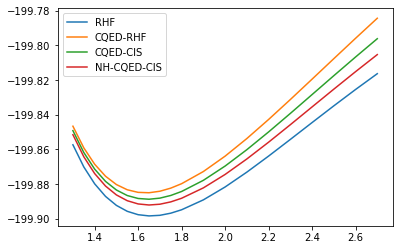

In [7]:
plt.plot(r_array, gs_energy_array[0,:], label='RHF')
plt.plot(r_array, gs_energy_array[1,:], label='CQED-RHF')
plt.plot(r_array, gs_energy_array[2,:], label='CQED-CIS')
plt.plot(r_array, gs_energy_array[3,:], label='NH-CQED-CIS')
plt.legend()
plt.show()


In [55]:
f = open('MgH_gs_lamz_7.5mH_om_4.75.txt', 'w')
stri = "r; rhf_e, cqed_rhf_e, cqed_cis_e"
f.write(" %s \n" % stri)
ctr=0
for r in r_array:
    f.write("%6.3f %12.6f %12.6f %12.6f \n" % 
            (r, gs_energy_array[0,ctr], gs_energy_array[1,ctr], gs_energy_array[1,ctr]+gs_energy_array[2,ctr]))
    ctr += 1
    
f.close()

<ipython-input-55-2d2baa3ed333>:6: ComplexWarning: Casting complex values to real discards the imaginary part
  f.write("%6.3f %12.6f %12.6f %12.6f \n" %


#### Model system
We will consider the diatomic cation MgH+ in a cavity chosen such that it can trap a photon with a 
frequency of $\hbar \omega = 4.3$ eV. 
We will compute the singlet ground state and first singlet excited state potential energy surfaces along the
Mg-H+ stretch coordinate using time-dependent density functional theory.  We denote the ground 
state ket as $|g\rangle$ with an associated energy eigenvalue $E_g(R)$, and the excited-state $|e\rangle$
with associated energy eigenvalue $E_e(R)$ where $R$ is the bondlength.  The transition dipole
moment between $|g\rangle$ and $|e\rangle$ will also be computed using CIS, yielding $\mu_{ge}(R)$.
Both the ground and excited states have total dipole moments associated with them, $\langle \mu \rangle_g$ and
$\langle \mu \rangle_e$, respectively.

We will consider two quantum states for the photon - no photon in the cavity, denoted by $|0\rangle$ with associated energy eigenvalue $0$
and one photon in the cavity, denoted by $|1\rangle$ with associated energy eigenvalue $\frac{ \hbar \omega}{2}$.  
We will model this system with a Pauli-Fierz Hamiltonian that can be written as:

$$ \hat{H}_{PF} = E_g(R) \hat{a}_g^{\dagger} \hat{a}_g + E_e(R) \hat{a}_e^{\dagger} \hat{a}_e + 
\hbar \omega\hat{b} \hat{b}^{\dagger}  
+ \frac{1}{2} \left( \lambda \cdot \mu(R) \right)^2
- \sqrt{\frac{\omega}{2}} \left( \lambda \cdot \mu(R) \right) \left(\hat{b}^{\dagger} + \hat{b}\right)
$$
The polaritonic potential energy surfaces may be obtained by building a Hamiltonian matrix in the following basis and diagonalizing as a function of the bond length $R$: $ |\phi\rangle \in \{|g,0\rangle , |g,1\rangle , |e,0\rangle. $


This matrix as a function of the bond-length $R$ is as follows:
\begin{equation}
{\bf H}(R)
  \mbox{=} 
  \begin{array}{c|cccc}
       & |g,0\rangle & |g,1\rangle & |e,0\rangle \\
    \hline
    \langle g,0| & E_g(R) + (\lambda \cdot \langle \mu \rangle_g)^2  &     0   & 0  \\
    \langle g,1| & 0        &   E_g(R) +  \hbar \omega + \frac{1}{2}(\lambda \cdot \langle \mu \rangle_g)^2  & \sqrt{\frac{\omega}{2}} \lambda \cdot \mu_{ge} \\
    \langle e,0| & 0        &    \sqrt{\frac{\omega}{2}} \lambda \cdot \mu_{ge} & E_e(R) + \frac{1}{2}(\lambda \cdot \langle \mu \rangle_e)^2\\
  \end{array}
\end{equation}

In [ ]:
from numpy import linalg as LA
from scipy.interpolate import InterpolatedUnivariateSpline

# fit splines in case you want polaritonic states at finer spacings
cis_s0_spline = InterpolatedUnivariateSpline(r_array, cis_energy_array[0,:], k=3)
cis_s1_spline = InterpolatedUnivariateSpline(r_array, cis_energy_array[1,:], k=3)

tdm_spline = InterpolatedUnivariateSpline(r_array, np.abs(tdm_array[2,:]), k=3 )

mu_g_spline = InterpolatedUnivariateSpline(r_array, dipole_array[2,0,:])
mu_e_spline = InterpolatedUnivariateSpline(r_array, dipole_array[2,1,:])

E_au = np.sqrt(om/2) * l
Htot = np.zeros((3,3), dtype=complex)

''' Polaritonic Hamiltonian will have the following structure

    | E_g(r)+0.5*(l.<mu>_g)^2                   0                                         0              |
    | 0                           E_g(r) + h*om + 0.5*(l.<mu>_g)^2               E_au*mu_eg          |
    | 0                                     E_au*mu_eg                      E_e(r) + 0.5*(l.<mu>_e)^2    |
    
'''

pl_1 = np.zeros_like(r_array)
pl_2 = np.zeros_like(r_array)
pl_3 = np.zeros_like(r_array)
# build the hamiltonian matrix and diagonalize at each geometry
for i in range(0,len(r_array)):
    Htot[0,0] = cis_s0_spline(r_array[i]) + 0.5 * (l * mu_g_spline(r_array[i]))**2
    Htot[1,1] = cis_s0_spline(r_array[i]) + om + 0.5 * (l * mu_g_spline(r_array[i]))**2
    Htot[1,2] = E_au * tdm_spline(r_array[i])
    Htot[2,1] = E_au * tdm_spline(r_array[i])
    Htot[2,2] = cis_s1_spline(r_array[i]) + 0.5 * (l * mu_e_spline(r_array[i]))**2
    
    # diagonalize
    vals, vecs = LA.eig(Htot)
    idx = vals.argsort()[::1]
    vals = vals[idx]
    # store eigenvalues
    pl_1[i] = np.real(vals[0])
    pl_2[i] = np.real(vals[1])
    pl_3[i] = np.real(vals[2])





In [ ]:
# now plot the ordinary cis energies vs both the model and the cs-cqed-cis energies
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import rcParams


rcParams['font.family'] = 'serif'
rcParams['font.size'] = 12

plt.plot(r_array, cis_s0_spline(r_array)+om, 'red', label='X,1')
plt.plot(r_array, cis_s1_spline(r_array), 'blue', label='A,0')
plt.plot(r_array, pl_2, 'b--', label="Model LP")
plt.plot(r_array, pl_3, 'g--', label="Model UP")
plt.plot(r_array, cqed_cis_energy_array[1,:], 'bo', label="CQED-CIS LP")
plt.plot(r_array, cqed_cis_energy_array[2,:], 'go', label="CQED-CIS UP")

plt.xlabel("Bondlength (Angstroms)")
plt.ylabel("Energy (Hartrees)")
plt.legend()
#plt.savefig("mghplus_stretch.eps")
plt.show()

In [ ]:


f = open('MgH_ccpVDZ_Ez_5mH_om_4.75_0.1j_ComplexCoupling.txt', 'w')
stri = "radius; CIS X,1; CIS A,0; Model LP; Model UP; CQED-CIS LP; CQED-CIS UP"
f.write(" %s \n" % stri)
for i in range(len(r_array)):
    f.write("%6.3f %12.6f %12.6f %12.6f %12.6f %12.6f %12.6f \n" % 
            (r_array[i], cis_energy_array[0,i]+np.real(om), cis_energy_array[1,i], 
            np.real(pl_2[i]), np.real(pl_3[i]), np.real(cqed_cis_energy_array[1,i]), np.real(cqed_cis_energy_array[2,i])))
f.close()

In [ ]:
''' 
# this follows the ci-vector across the curve crossing
    # that occurs btw |X,1> and |A,0> without coupling
    if ctr>0 and np.isclose(l,0):
        ol11 = np.dot(cqed_cis_c[:,1], old_vecs[:,1])
        ol22 = np.dot(cqed_cis_c[:,2], old_vecs[:,2])
        ol12 = np.dot(cqed_cis_c[:,1], old_vecs[:,2])
        ol21 = np.dot(cqed_cis_c[:,2], old_vecs[:,1])

        print("Overlaps for r = ",r)
        print("<1|1>:",ol11)
        print("<2|2>:",ol22)
        print("<1|2>:",ol12)
        print("<2|1>:",ol21)
        if np.abs(ol12)>np.abs(ol11):
            temp_c1 = np.copy(cqed_cis_c[:,2])
            temp_c2 = np.copy(cqed_cis_c[:,1])
            temp_e1 = cqed_cis_e[2]
            temp_e2 = cqed_cis_e[1]
            
            cqed_cis_c[:,1] = np.copy(temp_c1)
            cqed_cis_c[:,2] = np.copy(temp_c2)
            cqed_cis_e[1] = temp_e1
            cqed_cis_e[2] = temp_e2
            
    old_vecs = np.copy(cqed_cis_c)
    #scf_e, cqed_cis_e, cqed_cis_c = cqed_cis(lam, molstr, options_dict, om)
    #cqed_cis_energy_array[0,ctr] = scf_e+om
'''